In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast

In [2]:
def load_list_from_file(file_path):
    with open(file_path, 'r') as file:
        data_str = file.read()
    data = [json.loads(line) for line in data_str.splitlines()]
    return data


def write_list_to_file(file_path, data):
    data_str = [str(item) for item in data]  # Convert float values to strings
    with open(file_path, 'w') as file:
        file.write('\n'.join(data_str))
        
def load_or_generate_data(file1, file2, generation_func1, generation_func2, args1=(), kwargs1={}, args2=(), kwargs2={}):
    """
    Load data from files if they exist, or generate data using specified functions.
    
    :param file1: the file path to load the first data from
    :param file2: the file path to load the second data from
    :param generation_func1: the function to generate the first data if the file doesn't exist
    :param generation_func2: the function to generate the second data if the file doesn't exist
    :param args1: tuple containing positional arguments for the first generation function
    :param kwargs1: dict containing keyword arguments for the first generation function
    :param args2: tuple containing positional arguments for the second generation function
    :param kwargs2: dict containing keyword arguments for the second generation function
    :return: a tuple containing the two datasets
    """
    
    if os.path.exists(file1) and os.path.exists(file2):
        data1 = load_list_from_file(file1)
        data2 = load_list_from_file(file2)
        print('Files exist!')
    else:
        print('Files do not exist, generating data...')
        data1 = generation_func1(*args1, **kwargs1)
        data2 = generation_func2(*args2, **kwargs2)
        
        if not os.path.exists(file1):
            write_list_to_file(file1, data1)
            
        if not os.path.exists(file2):
            write_list_to_file(file2, data2)
    
    return data1, data2

In [3]:
import networkx as nx

def generate_h_graph(epsilon, n):
    # Function to create one of the H_k graphs
    def create_hk_graph(k, delta):
        G = nx.MultiGraph()
        V = ['L', 'R', 's0'] + [f's{i},{j}' for i in range(1, delta + 1) for j in range(3)]
        G.add_nodes_from(V)

        # Add self-loops
        for v in V:
            G.add_edge(v, v)

        # Mapping and adding edges (assuming as before, replace with correct edge-adding rules)
        mapping = {'L': 'L', 'R': 'R', 's0': 'c0'}
        mapping.update({f's{i},{(k+j) % 3}': f'{prefix}{i}' for i in range(1, delta + 1) for j, prefix in enumerate(['c', 'b', 'a'])})

        # Add edges according to the mapping
        for v in mapping.values():
            if v != 'L' and v != 'R':
                G.add_edge(v, 'L')
                G.add_edge(v, 'R')

        return G

    # Create the evolving graph H as a sequence of states
    delta = 2 * n
    time_steps = []
    for i in range(3):
        Hi = create_hk_graph(i, delta)
        num_copies = int(n**(1 - epsilon))
        for _ in range(num_copies):
            time_steps.append(Hi.copy())

    return time_steps

# Example usage:
# This will generate a sequence of graph states for epsilon=0.3 and n=10.
H_sequence = generate_h_graph(0.3, 2)

def plot_h_sequence(h_sequence, delay=1):
    plt.ion()

    for t, G in enumerate(h_sequence):
        plt.clf()
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True)
        plt.title(f"Temporal Helix Graph at Time Step {t+1}")
        plt.draw()
        plt.pause(delay)

    plt.ioff()
    plt.show()

# Example usage:
# Plot the H_sequence with a delay of 1 second between each graph.
# plot_h_sequence(H_sequence, delay=1)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def create_hk_graph(k, delta):
    G = nx.Graph()
    V = ['L', 'R', 's0'] + [f's{i},{j}' for i in range(1, delta + 1) for j in range(3)]
    
    # Base vertices
    G.add_nodes_from(['L', 'R', 'c0'])
    
    # Additional vertices and edges
    for i in range(1, delta + 1):
        for j in range(3):
            vertex = f's{i},{(k+j) % 3}'
            G.add_node(vertex)
            if j == k % 3:
                G.add_edge(vertex, 'c0')
            if j == (k+1) % 3:
                G.add_edge(vertex, 'L')
            if j == (k+2) % 3:
                G.add_edge(vertex, 'R')

    # Adding self-loops to make the probability 1/2 of staying in the same vertex
    for v in G.nodes():
        G.add_edge(v, v)

    return G

def generate_h_graph(epsilon, n):
    delta = 2 * n
    time_steps = []
    for i in range(3):
        Hi = create_hk_graph(i, delta)
        num_copies = int(n**(1 - epsilon))
        for _ in range(num_copies):
            time_steps.append(Hi.copy())
    return time_steps

def plot_h_sequence(h_sequence, delay=1):
    plt.ion()

    for t, G in enumerate(h_sequence):
        plt.clf()
        pos = nx.spring_layout(G, seed=42) # Using a fixed seed for consistent layout
        nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
        plt.title(f"Temporal Helix Graph at Time Step {t+1}")
        plt.draw()
        plt.pause(delay)

    plt.ioff()
    plt.show()

# Generate the sequence of graph states for epsilon=0.3 and n=10.
H_sequence = generate_h_graph(0.01, 10)

# Plot the H_sequence with a delay of 1 second between each graph.
# plot_h_sequence(H_sequence, delay=1)


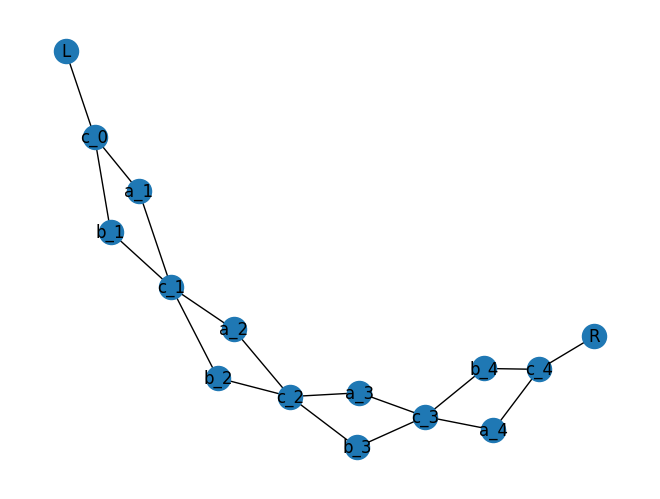

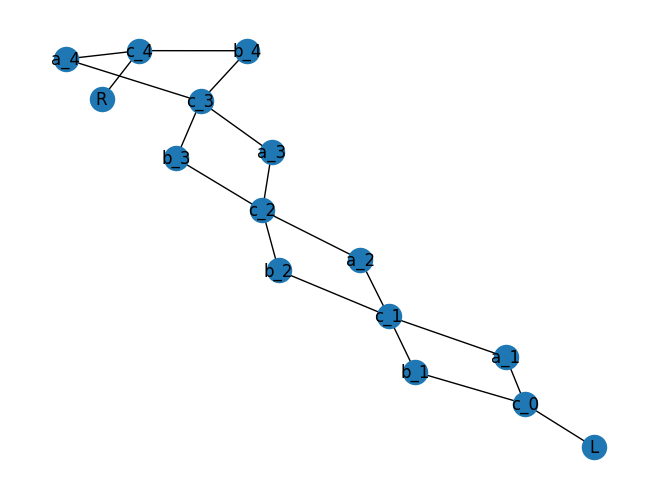

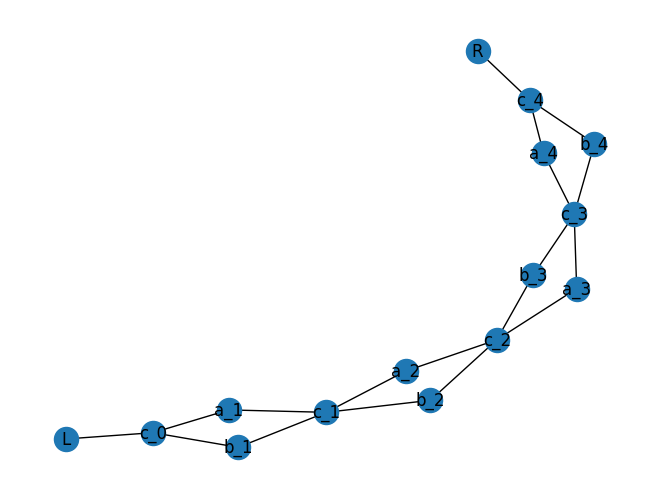

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

def create_graph(l, k):
    V = ["L", "R", "s_0"] + [f"s_{i},{j}" for i in range(1, l+1) for j in range(3)]
    H = nx.Graph()  # Graph is undirected

    H.add_nodes_from(V)
    mapping = {"L": "L", "R": "R", "s_0": "c_0"}
    mapping.update({f"s_{i},{k}": f"c_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+1)%3}": f"b_{i}" for i in range(1, l+1)})
    mapping.update({f"s_{i},{(k+2)%3}": f"a_{i}" for i in range(1, l+1)})

    H = nx.relabel_nodes(H, mapping)

    # add edges
    H.add_edge("L", "c_0")
    for i in range(1, l):
        H.add_edge(f"c_{i-1}", f"a_{i}")
        H.add_edge(f"c_{i-1}", f"b_{i}")
        H.add_edge(f"a_{i}", f"c_{i}")
        H.add_edge(f"b_{i}", f"c_{i}")
    H.add_edge(f"c_{l-1}", f"a_{l}")
    H.add_edge(f"c_{l-1}", f"b_{l}")
    H.add_edge(f"a_{l}", f"c_{l}")
    H.add_edge(f"b_{l}", f"c_{l}")
    H.add_edge(f"c_{l}", "R")

    return H

def draw_graph(H):
    pos = nx.spring_layout(H)
    nx.draw(H, pos, with_labels=True)
    plt.show()


def create_evolving_graph(n, epsilon):
    sequence = []
    for i in range(int(n**(1-epsilon))):
        for j in range(3):
            sequence.append(create_graph(2*n, j))
    return sequence

def draw_evolving_graph(sequence):
    for i, H in enumerate(sequence):
        plt.figure(i)
        draw_graph(H)

epsilon = 0.5
n = 2
sequence = create_evolving_graph(n, epsilon)
draw_evolving_graph(sequence)
